In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List, Any, Optional
from langchain_core.messages import HumanMessage
import json
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()
llm_key = os.getenv('llm_key')

In [2]:
model=ChatOpenAI(model="openai/gpt-oss-20b:free",
                        api_key=llm_key,
                        base_url="https://openrouter.ai/api/v1")

In [7]:
class GraphState(TypedDict):
    user_request: str
    workflow_analysis: Dict[str, Any]  # AI-generated workflow understanding
    approval_chain: List[Dict[str, Any]]  # Dynamic approval hierarchy
    questions: Dict[str, Any]
    answers: Dict[str, Any]
    validation: Dict[str, Any]
    workflow: Dict[str, Any]
    form_schema: Dict[str, Any]
    excel_schema: Dict[str, Any]
    custom_rules: List[Dict[str, Any]]  # User-specific business rules
    iteration_count: int
    refinement_needed: bool
    conversation_history: List[str]  # Track clarifications

In [8]:
def analyze_request(state: GraphState):
    """
    Deep AI analysis - understand EVERYTHING about the workflow from user description
    """
    
    prompt = f"""
You are an expert workflow architect. Analyze this workflow request in detail.

User Request: {state['user_request']}

Previous Conversation: {state.get('conversation_history', [])}

Extract and return a comprehensive workflow analysis in VALID JSON format:

{{
  "workflow_name": "descriptive name",
  "workflow_description": "detailed description",
  "workflow_purpose": "what problem does this solve",
  
  "stakeholders": [
    {{
      "role": "Student/Faculty/Staff",
      "actions": ["submit request", "receive notifications"],
      "required_info": ["name", "email", "id"]
    }}
  ],
  
  "approval_chain": [
    {{
      "level": 1,
      "approver_role": "Class Teacher",
      "approver_type": "single|multiple|any",
      "conditions": ["must approve first", "can add comments"],
      "rejection_behavior": "end_workflow|send_back|escalate"
    }},
    {{
      "level": 2,
      "approver_role": "Mentor",
      "approver_type": "single",
      "parallel_with_level": 1,
      "conditions": ["must approve before director"],
      "rejection_behavior": "send_back"
    }},
    {{
      "level": 3,
      "approver_role": "Director",
      "approver_type": "single",
      "requires_all_previous": true,
      "final_authority": true,
      "conditions": ["makes final decision"],
      "rejection_behavior": "end_workflow"
    }}
  ],
  
  "required_documents": [
    {{
      "name": "Leave Application Form",
      "format": [".pdf", ".docx"],
      "required": true,
      "max_size_mb": 5
    }}
  ],
  
  "data_to_collect": [
    {{
      "field_name": "leave_start_date",
      "label": "Leave Start Date",
      "type": "date",
      "required": true,
      "validation": "must be future date"
    }},
    {{
      "field_name": "leave_end_date",
      "label": "Leave End Date", 
      "type": "date",
      "required": true,
      "validation": "must be after start date"
    }},
    {{
      "field_name": "reason",
      "label": "Reason for Leave",
      "type": "textarea",
      "required": true,
      "validation": "minimum 50 characters"
    }},
    {{
      "field_name": "contact_during_leave",
      "label": "Contact Number During Leave",
      "type": "phone",
      "required": false
    }}
  ],
  
  "notifications": [
    {{
      "trigger": "form_submitted",
      "recipients": ["submitter", "class_teacher", "mentor"],
      "template": "confirmation"
    }},
    {{
      "trigger": "approved_by_class_teacher",
      "recipients": ["submitter", "mentor"],
      "template": "approval_progress"
    }},
    {{
      "trigger": "final_approval",
      "recipients": ["submitter", "all_approvers", "hr"],
      "template": "final_decision"
    }},
    {{
      "trigger": "rejected",
      "recipients": ["submitter", "rejecting_approver"],
      "template": "rejection_notice"
    }}
  ],
  
  "tracking_requirements": [
    "submission_timestamp",
    "current_status",
    "approval_history",
    "comments_at_each_level",
    "time_spent_at_each_level",
    "final_decision",
    "days_of_leave_approved"
  ],
  
  "business_rules": [
    "Class Teacher AND Mentor must both approve before going to Director",
    "If either Class Teacher or Mentor rejects, workflow ends",
    "Director sees all previous approvals and comments",
    "Cannot apply for leave during exam periods (add date validation)",
    "Maximum 10 days of leave per request"
  ],
  
  "special_features": [
    "Allow approvers to add conditional approval comments",
    "Send reminder if no action taken within 48 hours",
    "Allow submitter to withdraw request before final approval",
    "Generate PDF summary after final approval"
  ]
}}

Return ONLY valid JSON. Be thorough and extract ALL implicit requirements from the user's description.
"""

    # In production, replace with actual LLM call
    # response = model.invoke([HumanMessage(content=prompt)])
    # analysis = json.loads(response.content)
    
    # Simulated response for demonstration
    analysis = {
        "workflow_name": "Student Leave Request Workflow",
        "workflow_description": "Comprehensive leave request system for students with multi-level approval",
        "workflow_purpose": "Streamline leave requests while ensuring proper oversight from class teacher, mentor, and director",
        
        "stakeholders": [
            {
                "role": "Student",
                "actions": ["submit request", "receive notifications", "track status"],
                "required_info": ["name", "email", "student_id", "class", "department"]
            },
            {
                "role": "Class Teacher",
                "actions": ["review request", "approve/reject", "add comments"],
                "required_info": ["email"]
            },
            {
                "role": "Mentor",
                "actions": ["review request", "approve/reject", "add comments"],
                "required_info": ["email"]
            },
            {
                "role": "Director",
                "actions": ["final review", "final approval/rejection", "view all comments"],
                "required_info": ["email"]
            }
        ],
        
        "approval_chain": [
            {
                "level": 1,
                "approver_role": "Class Teacher",
                "approver_type": "single",
                "conditions": ["Must review first", "Can add comments and conditions"],
                "rejection_behavior": "end_workflow",
                "timeout_hours": 48
            },
            {
                "level": 2,
                "approver_role": "Mentor", 
                "approver_type": "single",
                "parallel_with_level": 1,
                "conditions": ["Must approve independently", "Can add academic concerns"],
                "rejection_behavior": "end_workflow",
                "timeout_hours": 48
            },
            {
                "level": 3,
                "approver_role": "Director",
                "approver_type": "single",
                "requires_all_previous": True,
                "final_authority": True,
                "conditions": ["Reviews all previous approvals", "Makes final decision", "Can modify leave duration"],
                "rejection_behavior": "end_workflow",
                "timeout_hours": 72
            }
        ],
        
        "required_documents": [
            {
                "name": "Leave Application Letter",
                "format": [".pdf", ".docx"],
                "required": True,
                "max_size_mb": 5,
                "description": "Formal leave application"
            },
            {
                "name": "Supporting Documents",
                "format": [".pdf", ".jpg", ".png"],
                "required": False,
                "max_size_mb": 10,
                "description": "Medical certificates or other supporting documents"
            }
        ],
        
        "data_to_collect": [
            {
                "field_name": "student_name",
                "label": "Full Name",
                "type": "text",
                "required": True,
                "validation": "string"
            },
            {
                "field_name": "student_email",
                "label": "University Email",
                "type": "email",
                "required": True,
                "validation": "email"
            },
            {
                "field_name": "student_id",
                "label": "Student ID",
                "type": "text",
                "required": True,
                "validation": "alphanumeric"
            },
            {
                "field_name": "class_section",
                "label": "Class/Section",
                "type": "text",
                "required": True,
                "validation": "string"
            },
            {
                "field_name": "leave_type",
                "label": "Type of Leave",
                "type": "choice",
                "choices": ["Medical", "Personal", "Family Emergency", "Other"],
                "required": True
            },
            {
                "field_name": "leave_start_date",
                "label": "Leave Start Date",
                "type": "date",
                "required": True,
                "validation": "must_be_future_date"
            },
            {
                "field_name": "leave_end_date",
                "label": "Leave End Date",
                "type": "date",
                "required": True,
                "validation": "must_be_after_start_date"
            },
            {
                "field_name": "number_of_days",
                "label": "Number of Days",
                "type": "number",
                "required": True,
                "validation": "max_10_days",
                "auto_calculate": "end_date - start_date"
            },
            {
                "field_name": "reason",
                "label": "Detailed Reason for Leave",
                "type": "textarea",
                "required": True,
                "validation": "minimum_50_characters"
            },
            {
                "field_name": "contact_number",
                "label": "Contact Number During Leave",
                "type": "phone",
                "required": False
            },
            {
                "field_name": "alternate_contact",
                "label": "Emergency Contact",
                "type": "phone",
                "required": False
            }
        ],
        
        "notifications": [
            {
                "trigger": "form_submitted",
                "recipients": ["student", "class_teacher", "mentor"],
                "template": "submission_confirmation",
                "timing": "immediate"
            },
            {
                "trigger": "class_teacher_approved",
                "recipients": ["student", "mentor", "director"],
                "template": "level_1_approval",
                "timing": "immediate"
            },
            {
                "trigger": "mentor_approved",
                "recipients": ["student", "class_teacher", "director"],
                "template": "level_2_approval",
                "timing": "immediate"
            },
            {
                "trigger": "both_initial_approvals_received",
                "recipients": ["director"],
                "template": "director_review_needed",
                "timing": "immediate"
            },
            {
                "trigger": "director_approved",
                "recipients": ["student", "class_teacher", "mentor", "administration"],
                "template": "final_approval",
                "timing": "immediate",
                "attachments": ["approved_leave_document"]
            },
            {
                "trigger": "any_rejection",
                "recipients": ["student", "rejecting_approver"],
                "template": "rejection_notice",
                "timing": "immediate"
            },
            {
                "trigger": "48_hours_no_response",
                "recipients": ["pending_approver"],
                "template": "reminder",
                "timing": "scheduled"
            }
        ],
        
        "tracking_requirements": [
            "submission_id",
            "submission_timestamp",
            "student_details",
            "leave_dates_and_duration",
            "current_status",
            "class_teacher_decision",
            "class_teacher_comments",
            "class_teacher_timestamp",
            "mentor_decision",
            "mentor_comments",
            "mentor_timestamp",
            "director_decision",
            "director_comments",
            "director_timestamp",
            "time_at_each_level",
            "total_processing_time",
            "final_outcome",
            "approved_days"
        ],
        
        "business_rules": [
            "Both Class Teacher AND Mentor must approve before request goes to Director",
            "If either Class Teacher OR Mentor rejects, workflow terminates immediately",
            "Director can only see request after both initial approvals",
            "Director can modify approved leave duration",
            "Cannot request leave during examination periods",
            "Maximum 10 consecutive days per request",
            "Minimum 3 days notice required for non-emergency leave",
            "All approvers can see previous comments but not change previous decisions",
            "Student receives notification at each approval stage"
        ],
        
        "special_features": [
            "Automatic calculation of leave duration",
            "Conditional approval support (e.g., 'Approved pending medical certificate')",
            "Withdrawal option for student before Director approval",
            "Auto-reminder system for pending approvals",
            "Dashboard showing leave balance and history",
            "Generate official approval letter PDF",
            "Calendar integration for approved leaves",
            "Analytics on leave patterns and approval times"
        ]
    }
    
    print("\n🔍 WORKFLOW ANALYSIS COMPLETE")
    print(f"   Workflow: {analysis['workflow_name']}")
    print(f"   Approval Levels: {len(analysis['approval_chain'])}")
    print(f"   Data Fields: {len(analysis['data_to_collect'])}")
    print(f"   Business Rules: {len(analysis['business_rules'])}")
    
    return {
        "workflow_analysis": analysis,
        "approval_chain": analysis["approval_chain"],
        "conversation_history": state.get("conversation_history", []) + [f"Analyzed: {state['user_request']}"]
    }


def generate_questions(state: GraphState):
    """
    Generate questions dynamically based on AI workflow analysis
    """
    
    analysis = state.get("workflow_analysis", {})
    
    # AI already determined what data to collect
    data_fields = analysis.get("data_to_collect", [])
    documents = analysis.get("required_documents", [])
    
    questions = {
        "workflow_name": analysis.get("workflow_name", ""),
        "form_title": f"{analysis.get('workflow_name', 'Request Form')}",
        "form_description": analysis.get("workflow_description", ""),
        "required_fields": [],
        "optional_fields": [],
        "file_uploads": [],
        "auto_calculated_fields": []
    }
    
    # Convert AI analysis to form fields
    for field in data_fields:
        field_def = {
            "id": field["field_name"],
            "question": field["label"],
            "type": field["type"],
            "required": field["required"],
            "validation": field.get("validation", ""),
            "placeholder": f"Enter {field['label'].lower()}"
        }
        
        if field["type"] == "choice":
            field_def["choices"] = field.get("choices", [])
        
        if field.get("auto_calculate"):
            field_def["auto_calculate"] = field["auto_calculate"]
            questions["auto_calculated_fields"].append(field_def)
        
        if field["required"]:
            questions["required_fields"].append(field_def)
        else:
            questions["optional_fields"].append(field_def)
    
    # Add file uploads
    for doc in documents:
        questions["file_uploads"].append({
            "id": doc["name"].lower().replace(" ", "_"),
            "label": doc["name"],
            "description": doc.get("description", ""),
            "accepted_types": doc["format"],
            "max_size_mb": doc["max_size_mb"],
            "required": doc["required"]
        })
    
    print(f"\n📋 Generated {len(questions['required_fields'])} required fields")
    print(f"📎 {len(questions['file_uploads'])} document uploads configured")
    
    return {"questions": questions}


def collect_answers(state: GraphState):
    """
    Human-in-the-loop: Collect answers to generated questions
    """
    
    questions = state.get("questions", {})
    
    if not questions or "required_fields" not in questions:
        print("\n❌ No questions found in state.")
        return state

    answers = {}
    
    print(f"\n{'='*70}")
    print(f"📋 {questions.get('form_title', 'Workflow Configuration')}")
    print(f"{'='*70}")
    print(f"\n{questions.get('form_description', '')}\n")

    # Required fields
    print("\n🔴 REQUIRED FIELDS:\n")
    for field in questions["required_fields"]:
        while True:
            val = input(f"{field['question']} [{field['type']}]: ").strip()
            if val or not field['required']:
                answers[field["id"]] = val
                break
            else:
                print("   ⚠️  This field is required. Please provide a value.")

    # Optional fields
    if questions.get("optional_fields"):
        print("\n🔵 OPTIONAL FIELDS (press Enter to skip):\n")
        for field in questions["optional_fields"]:
            val = input(f"{field['question']} [{field['type']}]: ").strip()
            if val:
                answers[field["id"]] = val

    # File uploads (simulated)
    if questions.get("file_uploads"):
        print("\n📎 FILE UPLOADS:\n")
        for upload in questions["file_uploads"]:
            val = input(f"{upload['label']} (path or 'skip'): ").strip()
            if val and val.lower() != 'skip':
                answers[upload["id"]] = val

    return {"answers": answers}


def validate_answers(state: GraphState):
    """
    Validate collected answers for completeness and correctness
    """
    
    questions = state.get("questions", {})
    answers = state.get("answers", {})
    
    missing = []
    invalid = []
    
    # Check required fields
    for field in questions.get("required_fields", []):
        field_id = field["id"]
        
        if field_id not in answers or not answers[field_id]:
            missing.append(field["question"])
        else:
            # Basic validation
            val = answers[field_id]
            if field.get("validation") == "email" and "@" not in val:
                invalid.append(f"{field['question']} (invalid email format)")
    
    is_valid = len(missing) == 0 and len(invalid) == 0
    
    validation_result = {
        "valid": is_valid,
        "missing": missing,
        "invalid": invalid
    }
    
    if not is_valid:
        print("\n❌ VALIDATION FAILED:")
        if missing:
            print(f"\n   Missing fields: {', '.join(missing)}")
        if invalid:
            print(f"\n   Invalid fields: {', '.join(invalid)}")
    
    return {
        "validation": validation_result,
        "refinement_needed": not is_valid
    }


def generate_form_schema(state: GraphState):
    """
    Generate Microsoft Forms JSON schema
    """
    
    questions = state.get("questions", {})
    
    form_schema = {
        "title": questions.get("form_title", "University Workflow Form"),
        "description": questions.get("form_description", ""),
        "settings": {
            "one_response_per_user": True,
            "allow_anonymous": False,
            "confirmation_message": "Your request has been submitted successfully!"
        },
        "questions": []
    }
    
    # Add required fields
    for idx, field in enumerate(questions.get("required_fields", []), 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "type": field["type"],
            "title": field["question"],
            "required": field["required"],
            "validation": field.get("validation", ""),
            "placeholder": field.get("placeholder", "")
        })
    
    # Add optional fields
    for idx, field in enumerate(questions.get("optional_fields", []), len(form_schema["questions"]) + 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "type": field["type"],
            "title": field["question"],
            "required": False
        })
    
    return {"form_schema": form_schema}


def generate_excel_schema(state: GraphState):
    """
    Generate Excel tracking schema based on workflow analysis
    """
    
    analysis = state.get("workflow_analysis", {})
    questions = state.get("questions", {})
    approval_chain = state.get("approval_chain", [])
    tracking_reqs = analysis.get("tracking_requirements", [])
    
    columns = [
        {"name": "SubmissionID", "type": "text", "description": "Unique identifier"},
        {"name": "SubmissionTimestamp", "type": "datetime", "description": "When request was submitted"},
        {"name": "CurrentStatus", "type": "choice", "choices": [
            "Submitted",
            "Pending Level 1",
            "Pending Level 2", 
            "Pending Final Approval",
            "Approved",
            "Rejected",
            "Withdrawn"
        ]}
    ]
    
    # Add columns for each form field
    for field in questions.get("required_fields", []):
        columns.append({
            "name": field["question"].replace(" ", "_"),
            "type": "text",
            "description": f"User input: {field['question']}"
        })
    
    # Add approval tracking columns for EACH level in the chain
    for level_info in approval_chain:
        level = level_info["level"]
        role = level_info["approver_role"].replace(" ", "_")
        
        columns.extend([
            {
                "name": f"{role}_Status",
                "type": "choice",
                "choices": ["Pending", "Approved", "Rejected", "Conditional"],
                "description": f"Decision by {level_info['approver_role']}"
            },
            {
                "name": f"{role}_Name",
                "type": "text",
                "description": f"Name of {level_info['approver_role']}"
            },
            {
                "name": f"{role}_Email",
                "type": "text",
                "description": f"Email of {level_info['approver_role']}"
            },
            {
                "name": f"{role}_Timestamp",
                "type": "datetime",
                "description": f"When {level_info['approver_role']} made decision"
            },
            {
                "name": f"{role}_Comments",
                "type": "text",
                "description": f"Comments from {level_info['approver_role']}"
            },
            {
                "name": f"{role}_TimeSpent_Hours",
                "type": "number",
                "description": f"Hours spent at {level_info['approver_role']} level"
            }
        ])
    
    # Add final tracking columns
    columns.extend([
        {"name": "FinalDecision", "type": "choice", "choices": ["Approved", "Rejected", "Withdrawn"]},
        {"name": "FinalDecisionDate", "type": "datetime"},
        {"name": "TotalProcessingTime_Hours", "type": "number"},
        {"name": "ApprovedBy", "type": "text", "description": "Final approver name"},
        {"name": "RejectedBy", "type": "text", "description": "Who rejected if applicable"},
        {"name": "RejectionReason", "type": "text"},
        {"name": "WithdrawalReason", "type": "text"},
        {"name": "NotificationsSent", "type": "text", "description": "List of all notifications"}
    ])
    
    # Add any custom tracking from business rules
    for req in tracking_reqs:
        if not any(req in col["name"] for col in columns):
            columns.append({
                "name": req.replace(" ", "_"),
                "type": "text",
                "description": f"Custom tracking: {req}"
            })
    
    excel_schema = {
        "table_name": f"{analysis.get('workflow_name', 'Workflow').replace(' ', '_')}_Tracker",
        "location": "SharePoint/Shared Documents/Workflow Tracking",
        "file_name": f"{analysis.get('workflow_name', 'Workflow').replace(' ', '_')}_Database.xlsx",
        "columns": columns,
        "auto_sync": True,
        "indexed_columns": ["SubmissionID", "CurrentStatus", "SubmissionTimestamp"],
        "views": [
            {
                "name": "Pending Approvals",
                "filter": "CurrentStatus <> 'Approved' AND CurrentStatus <> 'Rejected'"
            },
            {
                "name": "Approved Requests",
                "filter": "CurrentStatus = 'Approved'"
            },
            {
                "name": "This Week's Submissions",
                "filter": "SubmissionTimestamp >= TODAY() - 7"
            }
        ]
    }
    
    print(f"\n📊 Excel schema generated with {len(columns)} columns")
    print(f"   Includes tracking for {len(approval_chain)} approval levels")
    
    return {"excel_schema": excel_schema}


def generate_power_automate_workflow(state: GraphState):
    """
    Generate complete Power Automate workflow with dynamic approval chain
    """
    
    analysis = state.get("workflow_analysis", {})
    answers = state.get("answers", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    approval_chain = state.get("approval_chain", [])
    notifications = analysis.get("notifications", [])
    business_rules = analysis.get("business_rules", [])
    
    workflow = {
        "name": analysis.get("workflow_name", ""),
        "description": analysis.get("workflow_description", ""),
        "trigger": {
            "type": "Microsoft Forms",
            "operation": "When a new response is submitted",
            "form_id": "{FORM_ID_TO_BE_CONFIGURED}",
            "parameters": {
                "form_name": form_schema.get("title", "")
            }
        },
        "variables": [],
        "actions": [],
        "approval_flow": [],
        "notification_flow": [],
        "business_rules": business_rules
    }
    
    # Initialize variables
    step_num = 1
    workflow["actions"].append({
        "step": step_num,
        "name": "Initialize Core Variables",
        "type": "Initialize variable",
        "variables": [
            {"name": "SubmissionID", "type": "String", "value": "@{guid()}"},
            {"name": "CurrentStatus", "type": "String", "value": "Submitted"},
            {"name": "SubmissionTimestamp", "type": "String", "value": "@{utcNow()}"},
            {"name": "ApprovalLevel", "type": "Integer", "value": 0},
            {"name": "AllApprovalsReceived", "type": "Boolean", "value": False},
            {"name": "WorkflowTerminated", "type": "Boolean", "value": False}
        ]
    })
    
    # Get form response details
    step_num += 1
    workflow["actions"].append({
        "step": step_num,
        "name": "Get Form Response Details",
        "type": "Microsoft Forms",
        "operation": "Get response details",
        "parameters": {
            "form_id": "{FORM_ID}",
            "response_id": "@{triggerBody()?['resourceData']?['id']}"
        }
    })
    
    # Create initial Excel row
    step_num += 1
    excel_row_values = {
        "SubmissionID": "@{variables('SubmissionID')}",
        "SubmissionTimestamp": "@{variables('SubmissionTimestamp')}",
        "CurrentStatus": "@{variables('CurrentStatus')}"
    }
    
    # Add all form fields to Excel
    for field in form_schema.get("questions", [])[:5]:
        excel_row_values[field["title"].replace(" ", "_")] = f"@{{body('Get_Form_Response_Details')?['{field['id']}'] }}"
    
    workflow["actions"].append({
        "step": step_num,
        "name": "Create Tracking Record in Excel",
        "type": "Excel Online (Business)",
        "operation": "Add a row into a table",
        "parameters": {
            "location": "SharePoint",
            "document_library": excel_schema.get("location", ""),
            "file": excel_schema.get("file_name", ""),
            "table": excel_schema.get("table_name", ""),
            "values": excel_row_values
        }
    })
    
    # Send initial confirmation
    step_num += 1
    submitter_email_field = next((f for f in form_schema.get("questions", []) if "email" in f.get("type", "").lower()), None)
    
    workflow["actions"].append({
        "step": step_num,
        "name": "Send Submission Confirmation",
        "type": "Office 365 Outlook",
        "operation": "Send an email (V2)",
        "parameters": {
            "to": f"@{{body('Get_Form_Response_Details')?['{submitter_email_field['id'] if submitter_email_field else 'email'}']}}",
            "subject": f"✅ {analysis.get('workflow_name', '')} - Submission Received",
            "body": f"""
<div style="font-family: Arial, sans-serif; max-width: 600px;">
    <h2 style="color: #0078d4;">Submission Confirmed</h2>
    <p>Your request has been successfully submitted and is now being processed.</p>
    
    <div style="background-color: #f3f2f1; padding: 15px; border-radius: 5px; margin: 20px 0;">
        <strong>Submission ID:</strong> @{{variables('SubmissionID')}}<br>
        <strong>Status:</strong> @{{variables('CurrentStatus')}}<br>
        <strong>Submitted:</strong> @{{variables('SubmissionTimestamp')}}
    </div>
    
    <h3>Approval Process:</h3>
    <ol>
        {"".join(f"<li>{level['approver_role']}</li>" for level in approval_chain)}
    </ol>
    
    <p>You will receive notifications as your request progresses through each approval level.</p>
    
    <p style="color: #666; font-size: 12px;">This is an automated message. Please do not reply.</p>
</div>
"""
        }
    })
    
    # Build dynamic approval chain
    step_num += 1
    
    # Group parallel approvals
    approval_levels = {}
    for approval in approval_chain:
        level = approval["level"]
        if level not in approval_levels:
            approval_levels[level] = []
        approval_levels[level].append(approval)
    
    # Process each approval level
    for level, approvers in sorted(approval_levels.items()):
        
        # Check if previous level(s) approved
        if level > 1:
            step_num += 1
            workflow["approval_flow"].append({
                "step": step_num,
                "name": f"Check Previous Level Approvals",
                "type": "Condition",
                "expression": {
                    "and": [
                        {"equals": ["@variables('WorkflowTerminated')", False]},
                        {"equals": ["@variables('ApprovalLevel')", level - 1]}
                    ]
                },
                "if_yes": "continue",
                "if_no": "skip_to_end"
            })
        
        # Handle parallel approvals at same level
        if len(approvers) > 1:
            step_num += 1
            workflow["approval_flow"].append({
                "step": step_num,
                "name": f"Level {level} - Parallel Approval Setup",
                "type": "Scope",
                "description": f"Both {' and '.join([a['approver_role'] for a in approvers])} must approve",
                "parallel_execution": True
            })
        
        # Create approval action for each approver
        for approver in approvers:
            step_num += 1
            approver_role = approver["approver_role"]
            approver_field = approver_role.replace(" ", "_").lower()
            
            workflow["approval_flow"].append({
                "step": step_num,
                "name": f"Approval Request - {approver_role}",
                "type": "Start and wait for an approval",
                "approval_type": "Approve/Reject - First to respond",
                "parameters": {
                    "title": f"🔔 {analysis.get('workflow_name', '')} - Approval Required",
                    "assigned_to": f"{{{approver_role.upper().replace(' ', '_')}_EMAIL}}",
                    "details": f"""
<h3>Approval Request - Level {level}</h3>

<strong>Requester:</strong> @{{body('Get_Form_Response_Details')?['student_name']}}<br>
<strong>Submission ID:</strong> @{{variables('SubmissionID')}}<br>
<strong>Submitted:</strong> @{{variables('SubmissionTimestamp')}}

<h4>Request Details:</h4>
@{{body('Get_Form_Response_Details')?['reason']}}

<h4>Previous Approvals:</h4>
{self._generate_previous_approvals_display(approval_chain, level)}

<strong>Timeout:</strong> {approver.get('timeout_hours', 48)} hours

<p><em>Business Rules:</em></p>
<ul>
    {"".join(f"<li>{rule}</li>" for rule in business_rules[:3])}
</ul>
""",
                    "item_link": "@{concat('https://your-sharepoint.com/tracking/', variables('SubmissionID'))}",
                    "item_link_description": "View Full Request in System",
                    "enable_comments": True,
                    "enable_notifications": True,
                    "enable_reassignment": False
                },
                "timeout": {
                    "duration": f"PT{approver.get('timeout_hours', 48)}H",
                    "action": "send_reminder"
                }
            })
            
            # Update Excel with approval decision
            step_num += 1
            workflow["approval_flow"].append({
                "step": step_num,
                "name": f"Update Excel - {approver_role} Decision",
                "type": "Excel Online (Business)",
                "operation": "Update a row",
                "parameters": {
                    "location": "SharePoint",
                    "document_library": excel_schema.get("location", ""),
                    "file": excel_schema.get("file_name", ""),
                    "table": excel_schema.get("table_name", ""),
                    "key_column": "SubmissionID",
                    "key_value": "@{variables('SubmissionID')}",
                    "values": {
                        f"{approver_role.replace(' ', '_')}_Status": f"@{{body('Approval_Request_-_{approver_role}')?['outcome']}}",
                        f"{approver_role.replace(' ', '_')}_Name": f"@{{body('Approval_Request_-_{approver_role}')?['responder']?['displayName']}}",
                        f"{approver_role.replace(' ', '_')}_Email": f"@{{body('Approval_Request_-_{approver_role}')?['responder']?['email']}}",
                        f"{approver_role.replace(' ', '_')}_Timestamp": "@{utcNow()}",
                        f"{approver_role.replace(' ', '_')}_Comments": f"@{{body('Approval_Request_-_{approver_role}')?['comments']}}"
                    }
                }
            })
            
            # Handle rejection
            step_num += 1
            rejection_behavior = approver.get("rejection_behavior", "end_workflow")
            
            workflow["approval_flow"].append({
                "step": step_num,
                "name": f"Check {approver_role} Decision",
                "type": "Condition",
                "expression": {
                    "equals": [f"@{{body('Approval_Request_-_{approver_role}')?['outcome']}}", "Reject"]
                },
                "if_yes": {
                    "actions": [
                        {
                            "name": "Set Workflow Terminated",
                            "type": "Set variable",
                            "variable": "WorkflowTerminated",
                            "value": True
                        },
                        {
                            "name": "Update Status to Rejected",
                            "type": "Set variable",
                            "variable": "CurrentStatus",
                            "value": "Rejected"
                        },
                        {
                            "name": "Send Rejection Notification",
                            "type": "Office 365 Outlook",
                            "operation": "Send an email (V2)",
                            "to": f"@{{body('Get_Form_Response_Details')?['{submitter_email_field['id'] if submitter_email_field else 'email'}']}}",
                            "subject": f"❌ {analysis.get('workflow_name', '')} - Request Rejected",
                            "body": f"""
<div style="font-family: Arial, sans-serif;">
    <h2 style="color: #d13438;">Request Rejected</h2>
    <p>Your request has been rejected by {approver_role}.</p>
    
    <div style="background-color: #fef0f0; padding: 15px; border-left: 4px solid #d13438; margin: 20px 0;">
        <strong>Rejected by:</strong> @{{body('Approval_Request_-_{approver_role}')?['responder']?['displayName']}}<br>
        <strong>Date:</strong> @{{utcNow()}}<br>
        <strong>Comments:</strong><br>
        @{{body('Approval_Request_-_{approver_role}')?['comments']}}
    </div>
    
    <p>If you have questions, please contact {approver_role}.</p>
</div>
"""
                        }
                    ]
                },
                "if_no": "continue"
            })
        
        # After all approvers at this level - check if all approved
        if len(approvers) > 1:
            step_num += 1
            workflow["approval_flow"].append({
                "step": step_num,
                "name": f"Verify All Level {level} Approvals",
                "type": "Condition",
                "description": f"Check that all {len(approvers)} approvers at level {level} approved",
                "expression": {
                    "and": [
                        {"equals": [f"@{{body('Approval_Request_-_{app['approver_role']}')?['outcome']}}", "Approve"]}
                        for app in approvers
                    ]
                },
                "if_yes": {
                    "actions": [
                        {
                            "name": f"Increment Approval Level to {level + 1}",
                            "type": "Set variable",
                            "variable": "ApprovalLevel",
                            "value": level
                        },
                        {
                            "name": "Update Status",
                            "type": "Set variable",
                            "variable": "CurrentStatus",
                            "value": f"Pending Level {level + 1}" if level < len(approval_levels) else "Final Approval Pending"
                        }
                    ]
                },
                "if_no": {
                    "actions": [
                        {
                            "name": "Terminate Workflow - Not All Approved",
                            "type": "Set variable",
                            "variable": "WorkflowTerminated",
                            "value": True
                        }
                    ]
                }
            })
    
    # Final approval received
    step_num += 1
    final_approver = approval_chain[-1]["approver_role"]
    
    workflow["actions"].append({
        "step": step_num,
        "name": "Final Approval Processing",
        "type": "Condition",
        "expression": {
            "and": [
                {"equals": [f"@{{body('Approval_Request_-_{final_approver}')?['outcome']}}", "Approve"]},
                {"equals": ["@variables('WorkflowTerminated')", False]}
            ]
        },
        "if_yes": {
            "actions": [
                {
                    "name": "Update Final Status",
                    "type": "Excel Online (Business)",
                    "operation": "Update a row",
                    "parameters": {
                        "table": excel_schema.get("table_name", ""),
                        "key_column": "SubmissionID",
                        "key_value": "@{variables('SubmissionID')}",
                        "values": {
                            "CurrentStatus": "Approved",
                            "FinalDecision": "Approved",
                            "FinalDecisionDate": "@{utcNow()}",
                            "ApprovedBy": f"@{{body('Approval_Request_-_{final_approver}')?['responder']?['displayName']}}"
                        }
                    }
                },
                {
                    "name": "Generate Approval Document",
                    "type": "Word Online (Business)",
                    "operation": "Populate a template",
                    "parameters": {
                        "template": "{APPROVAL_LETTER_TEMPLATE}",
                        "data": {
                            "submission_id": "@{variables('SubmissionID')}",
                            "approval_date": "@{utcNow()}",
                            "all_form_data": "@{body('Get_Form_Response_Details')}"
                        }
                    }
                },
                {
                    "name": "Send Final Approval Email",
                    "type": "Office 365 Outlook",
                    "operation": "Send an email (V2)",
                    "to": f"@{{body('Get_Form_Response_Details')?['{submitter_email_field['id'] if submitter_email_field else 'email'}']}}",
                    "cc": f"{{{', '.join([a['approver_role'].upper().replace(' ', '_') + '_EMAIL' for a in approval_chain])}}}",
                    "subject": f"✅ {analysis.get('workflow_name', '')} - APPROVED",
                    "body": """
<div style="font-family: Arial, sans-serif;">
    <h2 style="color: #107c10;">Request Approved!</h2>
    <p>Congratulations! Your request has been fully approved.</p>
    
    <div style="background-color: #f0f9ff; padding: 20px; border-radius: 5px; margin: 20px 0;">
        <h3 style="margin-top: 0;">Approval Summary</h3>
        <strong>Final Approver:</strong> @{body('Approval_Request_-_Director')?['responder']?['displayName']}<br>
        <strong>Approval Date:</strong> @{utcNow()}<br>
        <strong>Submission ID:</strong> @{variables('SubmissionID')}
    </div>
    
    <p>Please find your official approval document attached.</p>
    
    <p>Thank you!</p>
</div>
""",
                    "attachments": [
                        {
                            "name": "Approval_Document.pdf",
                            "content_bytes": "@{body('Generate_Approval_Document')}"
                        }
                    ]
                }
            ]
        }
    })
    
    # Add notification handler
    for notification_config in notifications:
        workflow["notification_flow"].append({
            "trigger": notification_config["trigger"],
            "recipients": notification_config["recipients"],
            "template": notification_config["template"],
            "timing": notification_config.get("timing", "immediate")
        })
    
    print(f"\n⚙️ Generated complete Power Automate workflow")
    print(f"   Total actions: {len(workflow['actions']) + len(workflow['approval_flow'])}")
    print(f"   Approval levels: {len(approval_levels)}")
    print(f"   Notifications configured: {len(workflow['notification_flow'])}")
    
    return {"workflow": workflow}

def _generate_previous_approvals_display(self, approval_chain, current_level):
    """Helper to generate HTML for previous approvals"""
    if current_level == 1:
        return "<em>No previous approvals</em>"
    
    html = "<ul>"
    for approval in approval_chain[:current_level-1]:
        role = approval["approver_role"]
        html += f"""
        <li>
            <strong>{role}:</strong> 
            @{{{{body('Approval_Request_-_{role}')?['outcome']}}}} 
            by @{{{{body('Approval_Request_-_{role}')?['responder']?['displayName']}}}}
            <br><em>Comments: @{{{{body('Approval_Request_-_{role}')?['comments']}}}}</em>
        </li>
        """
    html += "</ul>"
    return html


def display_workflow(state: GraphState):
    """
    Display the generated workflow to the admin user
    """
    
    workflow = state.get("workflow", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    analysis = state.get("workflow_analysis", {})
    approval_chain = state.get("approval_chain", [])
    
    print("\n" + "="*80)
    print("✅ WORKFLOW GENERATION COMPLETE")
    print("="*80)
    
    print(f"\n📋 WORKFLOW: {workflow.get('name', '')}")
    print(f"📝 {workflow.get('description', '')}")
    
    print("\n" + "-"*80)
    print("🎯 WORKFLOW COMPONENTS:")
    print("-"*80)
    
    print(f"\n1️⃣  MICROSOFT FORM")
    print(f"    Name: {form_schema.get('title', '')}")
    print(f"    Fields: {len(form_schema.get('questions', []))} questions")
    print(f"    Required: {sum(1 for q in form_schema.get('questions', []) if q.get('required'))}")
    print(f"    File uploads: {len([q for q in form_schema.get('questions', []) if 'file' in q.get('type', '')])}")
    
    print(f"\n2️⃣  EXCEL TRACKER") 
    print(f"    Table: {excel_schema.get('table_name', '')}")
    print(f"    Location: {excel_schema.get('location', '')}")
    print(f"    Columns: {len(excel_schema.get('columns', []))}")
    print(f"    Views: {len(excel_schema.get('views', []))}")
    
    print(f"\n3️⃣  APPROVAL CHAIN ({len(approval_chain)} levels)")
    for level_info in approval_chain:
        print(f"    Level {level_info['level']}: {level_info['approver_role']}")
        print(f"       • Type: {level_info['approver_type']}")
        print(f"       • Timeout: {level_info.get('timeout_hours', 48)} hours")
        print(f"       • On Rejection: {level_info['rejection_behavior']}")
    
    print(f"\n4️⃣  NOTIFICATIONS")
    notif_count = len(analysis.get('notifications', []))
    print(f"    Configured: {notif_count} notification triggers")
    for notif in analysis.get('notifications', [])[:3]:
        print(f"    • {notif['trigger']}: {', '.join(notif['recipients'])}")
    
    print(f"\n5️⃣  BUSINESS RULES")
    rules = analysis.get('business_rules', [])
    print(f"    Total Rules: {len(rules)}")
    for idx, rule in enumerate(rules[:5], 1):
        print(f"    {idx}. {rule}")
    
    print("\n" + "-"*80)
    print("📊 WORKFLOW STATISTICS:")
    print("-"*80)
    print(f"  Total Actions: {len(workflow.get('actions', []))}")
    print(f"  Approval Steps: {len(workflow.get('approval_flow', []))}")
    print(f"  Variables: {len(workflow.get('variables', []))}")
    print(f"  Conditional Logic: {sum(1 for a in workflow.get('approval_flow', []) if a.get('type') == 'Condition')}")
    
    print("\n" + "-"*80)
    print("💾 EXPORT OPTIONS:")
    print("-"*80)
    print("  1. Complete Package (JSON) - All components")
    print("  2. Power Automate Workflow Only")
    print("  3. Microsoft Forms Schema Only")
    print("  4. Excel Tracking Schema Only")
    print("  5. Implementation Guide (Human Readable)")
    print("  6. All Separate Files")
    
    choice = input("\n📤 Select export option (1-6): ").strip()
    
    print("\n" + "="*80)
    
    if choice == "1":
        package = {
            "metadata": {
                "workflow_name": analysis.get("workflow_name"),
                "generated_at": "2024-12-02T10:00:00Z",
                "version": "1.0"
            },
            "workflow_analysis": analysis,
            "power_automate_workflow": workflow,
            "microsoft_forms_schema": form_schema,
            "excel_tracking_schema": excel_schema,
            "implementation_notes": {
                "step_1": "Import Microsoft Forms schema",
                "step_2": "Create Excel table in SharePoint using schema",
                "step_3": "Import Power Automate workflow",
                "step_4": "Configure email addresses for approvers",
                "step_5": "Test with sample submission",
                "step_6": "Deploy to production"
            }
        }
        print(json.dumps(package, indent=2))
        
    elif choice == "2":
        print(json.dumps(workflow, indent=2))
        
    elif choice == "3":
        print(json.dumps(form_schema, indent=2))
        
    elif choice == "4":
        print(json.dumps(excel_schema, indent=2))
        
    elif choice == "5":
        print(_generate_implementation_guide(analysis, workflow, form_schema, excel_schema, approval_chain))
        
    elif choice == "6":
        print("\n📁 Generating separate files...\n")
        print("=" *80)
        print("FILE 1: power_automate_workflow.json")
        print("="*80)
        print(json.dumps(workflow, indent=2))
        print("\n" + "="*80)
        print("FILE 2: microsoft_forms_schema.json")
        print("="*80)
        print(json.dumps(form_schema, indent=2))
        print("\n" + "="*80)
        print("FILE 3: excel_tracking_schema.json")
        print("="*80)
        print(json.dumps(excel_schema, indent=2))
        print("\n" + "="*80)
        print("FILE 4: workflow_analysis.json")
        print("="*80)
        print(json.dumps(analysis, indent=2))
    
    return state

def _generate_implementation_guide(analysis, workflow, form_schema, excel_schema, approval_chain):
    """Generate human-readable implementation guide"""
    
    guide = f"""
{'='*80}
IMPLEMENTATION GUIDE: {analysis.get('workflow_name', '')}
{'='*80}

OVERVIEW
--------
{analysis.get('workflow_description', '')}

PURPOSE
-------
{analysis.get('workflow_purpose', '')}

{'='*80}
STEP 1: CREATE MICROSOFT FORM
{'='*80}

1. Go to Microsoft Forms (forms.microsoft.com)
2. Create new form: "{form_schema.get('title', '')}"
3. Add the following questions:

"""
    
    for idx, field in enumerate(form_schema.get('questions', []), 1):
        guide += f"""
   Question {idx}: {field.get('title', field.get('question', ''))}
   - Type: {field.get('type', '')}
   - Required: {'Yes' if field.get('required') else 'No'}
   - Validation: {field.get('validation', 'None')}
"""
    
    guide += f"""

4. Configure form settings:
   - One response per person: Yes
   - Allow anonymous responses: No
   - Confirmation message: "{form_schema.get('settings', {}).get('confirmation_message', '')}"

{'='*80}
STEP 2: CREATE EXCEL TRACKING TABLE
{'='*80}

1. Go to SharePoint: {excel_schema.get('location', '')}
2. Create new Excel file: {excel_schema.get('file_name', '')}
3. Create table: {excel_schema.get('table_name', '')}
4. Add columns:

"""
    
    for col in excel_schema.get('columns', [])[:10]:
        guide += f"   • {col['name']} ({col['type']})\n"
    
    guide += f"\n   ... and {len(excel_schema.get('columns', [])) - 10} more columns\n"
    
    guide += f"""

5. Create views:
"""
    
    for view in excel_schema.get('views', []):
        guide += f"   • {view['name']}: {view['filter']}\n"
    
    guide += f"""

{'='*80}
STEP 3: CONFIGURE POWER AUTOMATE
{'='*80}

1. Go to Power Automate (flow.microsoft.com)
2. Create new automated flow
3. Name: "{workflow.get('name', '')}"
4. Trigger: Microsoft Forms - When a new response is submitted
5. Select your form from Step 1

CONFIGURE APPROVERS
-------------------
You need to configure email addresses for the following roles:

"""
    
    for level_info in approval_chain:
        guide += f"   • {level_info['approver_role'].upper().replace(' ', '_')}_EMAIL\n"
        guide += f"     Timeout: {level_info.get('timeout_hours', 48)} hours\n"
        guide += f"     Action on rejection: {level_info['rejection_behavior']}\n\n"
    
    guide += f"""

APPROVAL FLOW LOGIC
-------------------
"""
    
    for level_info in approval_chain:
        guide += f"\nLevel {level_info['level']}: {level_info['approver_role']}\n"
        for condition in level_info.get('conditions', []):
            guide += f"   - {condition}\n"
    
    guide += f"""

BUSINESS RULES IMPLEMENTED
---------------------------
"""
    
    for idx, rule in enumerate(analysis.get('business_rules', []), 1):
        guide += f"{idx}. {rule}\n"
    
    guide += f"""

{'='*80}
STEP 4: TEST THE WORKFLOW
{'='*80}

1. Submit a test form response
2. Verify email notifications sent
3. Check Excel row created
4. Test approval chain:
   - Approve at Level 1
   - Approve at Level 2
   - Final approval at Level 3
5. Verify final notification and document generation

TEST SCENARIOS TO COVER:
------------------------
1. Full approval path (all approvers approve)
2. Rejection at Level 1
3. Rejection at Level 2
4. Timeout scenario
5. Withdrawal request

{'='*80}
STEP 5: GO LIVE
{'='*80}

1. Share form with intended users
2. Communicate approval chain to all approvers
3. Set up monitoring dashboard in Excel
4. Document escalation procedures
5. Train support staff

SUPPORT CONTACTS
----------------
Form Issues: forms-support@university.edu
Workflow Issues: automation-support@university.edu
Excel Access: sharepoint-admin@university.edu

{'='*80}
END OF IMPLEMENTATION GUIDE
{'='*80}
"""
    
    return guide


# ============================================================================
# ROUTING FUNCTIONS
# ============================================================================

def should_refine_questions(state: GraphState) -> str:
    """
    Route based on validation results
    """
    if state.get("refinement_needed", False):
        iter_count = state.get("iteration_count", 0)
        if iter_count < 3:
            print("\n🔄 Refining questions based on validation feedback...")
            return "refine"
        else:
            print("\n⚠️ Max iterations reached. Proceeding with current answers...")
            return "proceed"
    return "proceed"


def route_after_validation(state: GraphState) -> str:
    """
    Determine next step after validation
    """
    return "generate_schemas" if state.get("validation", {}).get("valid") else "collect"


In [12]:
graph = StateGraph(GraphState)

# Add nodes
graph.add_node("analyze_request", analyze_request)
graph.add_node("generate_questions", generate_questions)
graph.add_node("collect_answers", collect_answers)
graph.add_node("validate_answers", validate_answers)
graph.add_node("generate_form_schema", generate_form_schema)
graph.add_node("generate_excel_schema", generate_excel_schema)
graph.add_node("generate_workflow", generate_power_automate_workflow)
graph.add_node("display_workflow", display_workflow)

# Define edges
graph.set_entry_point("analyze_request")
graph.add_edge("analyze_request", "generate_questions")
graph.add_edge("generate_questions", "collect_answers")
graph.add_edge("collect_answers", "validate_answers")

# Conditional edge after validation
graph.add_conditional_edges(
"validate_answers",
route_after_validation,
{
    "collect": "collect_answers",
    "generate_schemas": "generate_form_schema"
}
)

graph.add_edge("generate_form_schema", "generate_excel_schema")
graph.add_edge("generate_excel_schema", "generate_workflow")
graph.add_edge("generate_workflow", "display_workflow")
graph.add_edge("display_workflow", END)

app = graph.compile()

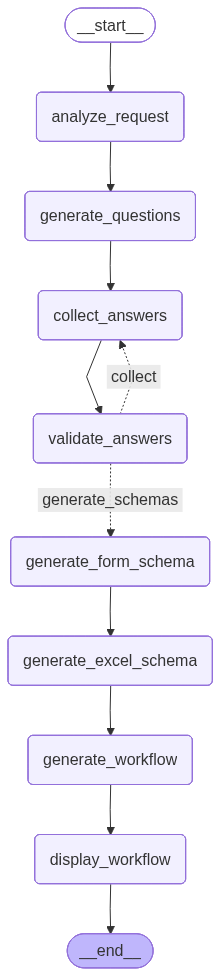

In [13]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
user_input = """
I need a student leave request workflow. Students should fill a form with their 
details, leave dates, and reason. The request must be approved by BOTH the class 
teacher AND the mentor before it goes to the director for final approval. If either 
the class teacher or mentor rejects, the workflow should end. The director should 
see all previous approvals and comments before making the final decision. We need 
to track everything in Excel and send notifications at each step.
"""
    
# Initialize state
initial_state = {
    "user_request": user_input,
    "workflow_analysis": {},
    "approval_chain": [],
    "questions": {},
    "answers": {},
    "validation": {},
    "workflow": {},
    "form_schema": {},
    "excel_schema": {},
    "custom_rules": [],
    "iteration_count": 0,
    "refinement_needed": False,
    "conversation_history": []
}

# Build and run graph
print("\n🚀 Generating workflow components...\n")
    
final_state = app.invoke(initial_state)


🚀 Generating workflow components...


🔍 WORKFLOW ANALYSIS COMPLETE
   Workflow: Student Leave Request Workflow
   Approval Levels: 3
   Data Fields: 11
   Business Rules: 9

📋 Generated 9 required fields
📎 2 document uploads configured

📋 Student Leave Request Workflow

Comprehensive leave request system for students with multi-level approval


🔴 REQUIRED FIELDS:


🔵 OPTIONAL FIELDS (press Enter to skip):


📎 FILE UPLOADS:


📊 Excel schema generated with 56 columns
   Includes tracking for 3 approval levels


NameError: name 'self' is not defined